<a href="https://colab.research.google.com/github/alexisdr/uned-tfg-deteccion-eas/blob/main/UNED-TFG-4-inferencia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Uso del modelo

Este cuaderno permite usar el modelo para efectuar una clasificación de texto

# Parámetros
* ruta_base: ruta en la que se encuentran los datos del corpus
* ruta_dataset: ruta en el que se almacenará el dataset
* usar_subconjunto_datos_codigos_mas_frecuentes: se usarán los actos clínicos que implican los códigos más frecuentes
* umbral: valor de corte que deberán superar las predicciones para tomarlas como ciertas

In [438]:
ruta_base = '/drive/My Drive/CorpusPFG/'

#Datasets procesados
ruta_dataset = ruta_base + 'Dataset-sin-apartados'
modelo_base = "alexisdr/uned-tfg-08.74"
usar_subconjunto_datos_codigos_mas_frecuentes = False
umbral = 0.9

Instalación de depndencias necesarias

In [346]:
!pip install datasets transformers[sentencepiece] 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Carga de datos del dataset

In [347]:
from google.colab import drive

drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [439]:
from datasets import DatasetDict

dataset = DatasetDict.load_from_disk(ruta_dataset)

dataset  

DatasetDict({
    train: Dataset({
        features: ['acto', 'label', 'label_str', 'label_list', 'label_list_str', 'informes', 'text', 'json'],
        num_rows: 2218
    })
    validation: Dataset({
        features: ['acto', 'label', 'label_str', 'label_list', 'label_list_str', 'informes', 'text', 'json'],
        num_rows: 247
    })
    test: Dataset({
        features: ['acto', 'label', 'label_str', 'label_list', 'label_list_str', 'informes', 'text', 'json'],
        num_rows: 3425
    })
    trainMasFrecuentes: Dataset({
        features: ['acto', 'label', 'label_str', 'label_list', 'label_list_str', 'informes', 'text', 'json'],
        num_rows: 634
    })
    validationMasFrecuentes: Dataset({
        features: ['acto', 'label', 'label_str', 'label_list', 'label_list_str', 'informes', 'text', 'json'],
        num_rows: 71
    })
    testMasFrecuentes: Dataset({
        features: ['acto', 'label', 'label_str', 'label_list', 'label_list_str', 'informes', 'text', 'json'],
       

In [440]:
train = "train"
validation = "validation"
test = "test"

if (usar_subconjunto_datos_codigos_mas_frecuentes):
  train = "trainMasFrecuentes"
  validation = "validationMasFrecuentes"
  test = "testMasFrecuentes"

In [441]:
from datasets import ClassLabel

class2label = dataset[train].features["label"]
print(class2label)

ClassLabel(names=['T50.2X5A', 'O90.0', 'T46.5X5A', 'E89.0', 'H59.022', 'Y84.2', 'T83.021A', 'K94.23', 'T50.8X5A', 'Y95', 'T50.905A', 'T50.0X5A', 'L27.0', 'T85.398A', 'T38.0X5A', 'T85.79XA', 'P39.1', 'T84.498A', 'T84.82XA', 'K91.841', 'I97.618', 'T80.1XXA', 'T84.89XA', 'T40.605A', 'R50.82', 'T81.4XXA', 'T38.3X5A', 'G97.1', 'O75.2', 'N99.820', 'T45.1X5A', 'T39.1X5A', 'T85.71XA', 'L76.02', 'K66.0', 'Y83.1', 'T82.120A', 'K12.31', 'P01.1', 'G25.1', 'G89.18', 'T38.0X5D', 'L76.31', 'M96.830', 'G97.41', 'T47.4X5A', 'N99.821', 'T45.515A', 'T80.211A', 'T46.2X5S', 'P36.9', 'T36.0X5A', 'T84.84XA', 'G62.0', 'D70.1', 'T82.868A', 'T79.6XXA', 'T40.2X5A', 'T39.395A', 'T41.5X5A', 'T84.223A', 'T45.1X5D', 'T83.498A', 'L76.22', 'T43.295A', 'K94.12', 'P39.8', 'O86.29', 'K91.71', 'T84.021A', 'M96.840', 'Y83.2', 'T87.81', 'I97.130', 'T46.0X5A', 'T84.51XA', 'P03.4', 'Y64.0', 'J95.811', 'T39.2X5A', 'G97.51', 'T48.6X5A', 'T45.615A', 'H59.021', 'T82.7XXA', 'T82.330A', 'T83.29XA', 'K94.29', 'E89.2', 'E36.01', 'T36

In [442]:
class2label.num_classes

485

# Preprocesado de los datos

El modelo no puede recibir texto como entrada, se ha de convertir a tokens.

In [443]:
from transformers import AutoTokenizer


tokenizer = AutoTokenizer.from_pretrained(modelo_base)

def preprocess_data(examples):
  return tokenizer(examples["text"], padding="max_length", truncation=True, return_tensors="pt")

# Cálculo de la métrica S

In [444]:
#Calcula el prefico comun entre 2 códigos
def calculo_lcs(codigo_i, codigo_j):
  if codigo_i is None or codigo_j is None:
    return ""

  #Se omiten los puntos existenten en los códigos
  codigo_i = codigo_i.replace(".", "")
  codigo_j = codigo_j.replace(".", "")

  #Tomamos el tamaño mínimo
  size = min(len(codigo_i), len(codigo_j)) 

  lcs_i_j = ''
  for i in range(size):
    if codigo_i[i] == codigo_j[i]:
      lcs_i_j = lcs_i_j + codigo_i[i]
    else:
      return lcs_i_j
  
  return lcs_i_j


#Devuelve la longitud de la cadena de caracteres C
#si esta vale al menos 3, y devuelve 0 si dicha longitud es menor que 3. 
#Esto se debe a que los códigos CIE-10 más cortos contienen al menos 3 caracteres.
def calculo_ic(codigo):
  #Se omiten los puntos existenten en los códigos
  codigo = codigo.replace(".", "")

  tamanyo = len(codigo)
  if (tamanyo < 3):
    return 0
  else:
    return tamanyo

#similitud entre 2 códigos CIE-10 𝑖 y 𝑗:
def calculo_c(codigo_i, codigo_j):
  divisor = calculo_ic(codigo_i) + calculo_ic(codigo_j)
  if (divisor == 0):
    return 0
  dividendo = 2 * calculo_ic(calculo_lcs(codigo_i, codigo_j))
  c_i_j = dividendo / divisor
  return round(c_i_j, 6)

def metrica_s(lista_codigos_i, lista_codigos_j): 
  #las listas deben tener valores 
  if (len(lista_codigos_i) == 0 or len(lista_codigos_j) == 0):
    return 0

  #max (Ng, Ns)
  divisor = max(len(lista_codigos_i), len(lista_codigos_j)) 
  if (divisor == 0):
    return 0
  
  max_c_i_j = 0
  for codigo_j in lista_codigos_j:
    max_local_c_i_j = 0
    for codigo_i in lista_codigos_i:
      c_i_j = calculo_c(codigo_i, codigo_j)
      if (c_i_j > max_local_c_i_j):
        max_local_c_i_j = c_i_j
    max_c_i_j += max_local_c_i_j

  s = max_c_i_j / divisor
  return round(s, 6)

def metrica_s_train (y_true, y_pred):     
    y_true_labels = []
    true_labels = [class2label.int2str([idx])for idx, label in enumerate(y_true) if label == 1.0]
    for label in true_labels:
      y_true_labels.append(label[0])

    y_pred_labels = []
    pred_labels = [class2label.int2str([idx])for idx, label in enumerate(y_pred) if label == 1.0]
    for label in pred_labels:
      y_pred_labels.append(label[0])

    return metrica_s(y_true_labels, y_pred_labels)

# Inferencia

Se ejecuta el modelo contra datos de test

**Cálculo de predicciones**

Solo asignar NONE si su probabilidad es mayor que la del resto de códigos y en caso contrario asignar sólo los códigos con mayor probabilidad que NONE

In [445]:
dataset[test]

Dataset({
    features: ['acto', 'label', 'label_str', 'label_list', 'label_list_str', 'informes', 'text', 'json'],
    num_rows: 3425
})

In [446]:
codigo_NONE = 'NONE'

def calcular_predicciones(probs, threshold=umbral):
  predictions = np.zeros(probs.shape)
  predictions[np.where(probs > threshold)] = 1
  return predictions

def calcular_predicciones_NONE_mas_probable(probs, threshold=umbral):
  predictions = calcular_predicciones(probs, threshold)

  try:
    probabilidad_NONE = probs[class2label.str2int(codigo_NONE)]
    #Se ha encontrado NONE entre las predicciones
    if (probabilidad_NONE > 0):
      predictions_mayor_que_prob_NONE = np.zeros(probs.shape)
      predictions_mayor_que_prob_NONE[np.where(probs > probabilidad_NONE)] = 1
      # Si hay labels con mejor probabilidad que none nos la quedamos
      if (1 in predictions_mayor_que_prob_NONE):
        predictions = predictions_mayor_que_prob_NONE
      else: #Si no las hay nos quedamos solo con NONE
        predictions[:] = 0
        predictions[class2label.str2int(codigo_NONE)] = 1
  except ValueError:
    pass      
    
  return predictions
    
#Solo asignar NONE si existe y tiene una probabilidad que supere el umbral
def calcular_predicciones_existe_NONE(probs, threshold=umbral):
  predictions = calcular_predicciones(probs, threshold)

  try:
    probabilidad_NONE = probs[class2label.str2int(codigo_NONE)]
    #Se ha encontrado NONE entre las predicciones, nos la quedamos de forma exclusiva
    if (probabilidad_NONE > threshold):
        predictions[:] = 0
        predictions[class2label.str2int(codigo_NONE)] = 1
  except ValueError:
    pass

  return predictions

In [447]:
# obtienen los nombres de las etiquetas predichas
def obtener_lables_predichas (y_pred):
  predicted_labels = [class2label.int2str([idx])for idx, label in enumerate(y_pred) if label == 1.0]
  y_pred_labels = []
  for label in predicted_labels:
      y_pred_labels.append(label[0])
  return y_pred_labels

# obtienen el vector y_true a partir de los labels 
def obtener_y_true (labels):
  # crea una matriz del tamaño del texto y las clases a entrenar
  labels_matrix = np.zeros(class2label.num_classes)
  for clase in labels:
    try:
      indice_clase = class2label.str2int(clase)
      labels_matrix[indice_clase] = 1
    except:
      print("La clase %s no está entre las clases de entrenamiento" % clase)
  return labels_matrix.tolist()

In [455]:
data = dataset[test][5]
data

{'acto': 24866030,
 'label': 1,
 'label_str': 'T38.0X5A',
 'label_list': [1],
 'label_list_str': ['T38.0X5A'],
 'informes': ['24866030-163595799.txt'],
 'text': 'mujer.   insuficiencia cardiaca izquierda. acidosis respiratoria secundaria a insuficiencia respiratoria global. descompensacion diabetica por corticoides. desaconsicionamiento fisico por proceso agudo en anciano fragil. los previos. ',
 'json': '[{"apartado": "sexo", "texto": "mujer."}, {"apartado": "juicio clinico insuficiencia cardiaca izquierda. acidosis respiratoria secundaria a insuficiencia respiratoria global. descompensacion diabetica por corticoides. desaconsicionamiento fisico por proceso agudo en anciano fragil. los previos.", "texto": " juicio clinico insuficiencia cardiaca izquierda. acidosis respiratoria secundaria a insuficiencia respiratoria global. descompensacion diabetica por corticoides. desaconsicionamiento fisico por proceso agudo en anciano fragil. los previos."}]'}

In [456]:
from transformers import AutoModelForSequenceClassification
import torch
import numpy as np

#obtiene el modelo
model = AutoModelForSequenceClassification.from_pretrained(
    modelo_base, 
    num_labels=class2label.num_classes, 
    problem_type = "multi_label_classification")

#procesa los datos
inputs = preprocess_data(data)
outputs = model(**inputs)

#obtiene las prediccciones y las probabilidades
logits = outputs.logits
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(logits.squeeze().cpu())

y_pred = calcular_predicciones_existe_NONE(probs)
y_pred_labels = obtener_lables_predichas(y_pred)

y_true = obtener_y_true(data['label_list_str'])
y_true_labels = data['label_list_str']

# Interpretación de los datos


In [457]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score

def calculo_metricas_multi_label(y_pred, y_true, threshold=umbral):    
    metric_average = "micro"
    precision_score_value = precision_score(y_true, y_pred, average=metric_average)
    recall_score_value = recall_score(y_true, y_pred, average=metric_average)
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average=metric_average)
    roc_auc = roc_auc_score(y_true, y_pred, average=metric_average)
    accuracy = accuracy_score(y_true, y_pred)
    metrica_s_value = metrica_s_train(y_true, y_pred)
    
    metrics = {
      'Métrica-s': round(metrica_s_value, 4), 
      'Precisión': round(precision_score_value, 2),
      'Recall': round(recall_score_value, 2),
      'F1': round(f1_micro_average, 2),
      'Accuracy': round(accuracy, 2)}

    return metrics

In [458]:
print('y_true_labels', y_true_labels)
print('y_pred_labels', y_pred_labels)
print('metricas', calculo_metricas_multi_label(y_pred, y_true))

y_true_labels ['T38.0X5A']
y_pred_labels ['NONE']
metricas {'Métrica-s': 0.0, 'Precisión': 1.0, 'Recall': 1.0, 'F1': 1.0, 'Accuracy': 1.0}


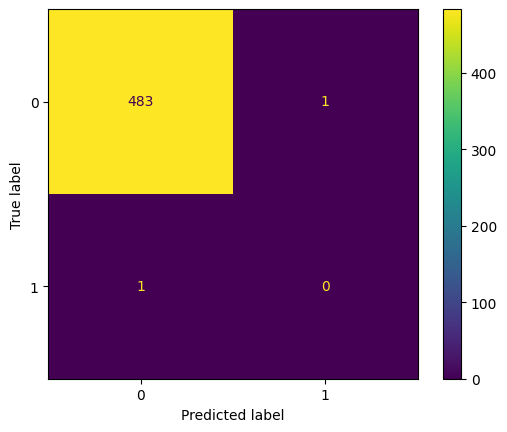

In [459]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm).plot()

In [460]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       484
         1.0       0.00      0.00      0.00         1

    accuracy                           1.00       485
   macro avg       0.50      0.50      0.50       485
weighted avg       1.00      1.00      1.00       485

